# Parallel Tempering for Bayesian Inference and Reliability analyses

The general framework: one wants to sample from a distribution of the form

$$ p_{1}(x) = \frac{q_{1}(x) p_{0}(x)}{Z_{1}} $$

where $q_{1}(x)$ and $p_{0}(x)$ can be evaluated; and potentially estimate the constant $Z_{1}=\int{q_{1}(x) p_{0}(x)dx}$. Parallel tempering introduces a sequence of auxiliary tempered densities:

$$ p_{T}(x) \propto q_{T}(x) p_{0}(x) $$ 

for increasing values of the temperature $T$. Setting $T=1$ equates sampling from the target, while $T \rightarrow \infty$ samples from the reference distribution $p_{0}$. Periodically during the run, the different temperatures swap members of their ensemble in a way that preserves detailed balance. The chains closer to the reference chain (hot chains) can sample from regions that have low probability under the target and thus allow a better exploration of the parameter space, while the cold chains can better explore the regions of high likelihood.

The normalizing constant $Z_{1}$ is estimated via thermodynamic integration, using re-parameterization $\beta = \frac{1}{T}$:

$$ \ln{Z_{\beta=1}} = \ln{Z_{\beta=0}} + \int_{0}^{1} E_{p_{\beta}} \left[ \frac{\partial \ln{q_{\beta}(x)}}{\partial \beta} \right] d\beta = \ln{Z_{\beta=0}} + \int_{0}^{1} E_{p_{\beta}} \left[ U_{\beta}(x) \right] d\beta$$

where $\ln{Z_{\beta=0}}=\int{q_{\beta=0}(x) p_{0}(x)dx}$ can be determined by simple MC sampling since $q_{\beta=0}(x)$ is close to the reference distribution $p_{0}$. The function $U_{\beta}(x)=\frac{\partial \ln{q_{\beta}(x)}}{\partial \beta}$ is called the potential, and can be evaluated using posterior samples from $p_{\beta}(x)$.

In the code, the user must define:
- a function to evaluate the reference distribution $p_{0}(x)$,
- a function to evaluate the tempered factor $p_{T}(x)$ (function that takes in two inputs: x and the temperature T),
- if evaluation of $Z_{1}$ is of interest, a function that evaluates the potential $U_{\beta}(x)$, from evaluations of $\ln{q_{\beta}(x)}$ which are saved during the MCMC run for the various chains (different $\beta$ values).

## Bayesian inference

In the Bayesian setting, $p_{0}$ is the prior and we have:

$$ q_{T}(x) = L(data; x) ^{1/T} $$

Then for the model evidence:

$$ U_{\beta}(x) = \ln{L(data; x)} $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from UQpy.RunModel import RunModel
from UQpy.Distributions import MVNormal, JointInd, Normal, Uniform
folder_uqpy_runs = '/Users/audreyolivier/Data/Trash_UQpy_runs/run'

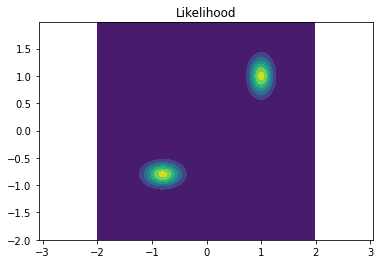

Evidence computed analytically = 0.062499877742670795


In [2]:
from scipy.stats import multivariate_normal, norm, uniform
# bimodal posterior
mu1 = np.array([1., 1.])
mu2 = -0.8 * np.ones(2)
w1 = 0.5
# Width of 0.1 in each dimension
sigma1 = np.diag([0.02, 0.05])
sigma2 = np.diag([0.05, 0.02])

def log_likelihood(x):
    # Posterior is a mixture of two gaussians
    return np.logaddexp(np.log(w1) + multivariate_normal.logpdf(x=x, mean=mu1, cov=sigma1),
                        np.log(1.-w1) + multivariate_normal.logpdf(x=x, mean=mu2, cov=sigma2))

def func_integration(x1, x2):
    x = np.array([x1, x2]).reshape((1, 2))
    return np.exp(log_likelihood(x)) * (1. / 4) ** 2

def log_prior(x):
    # Use a flat prior over a defined range [-2, 2], [-2, 2]
    loc = -2.
    scale = 4.
    return uniform.logpdf(x[:, 0], loc=loc, scale=scale) + uniform.logpdf(x[:, 1], loc=loc, scale=scale)
    #loc = -2
    #outpt = np.log(1. / (4. * 4.)) * np.ones((x.shape[0], ))
    #mask = [True if (np.abs(xi[0]) > 2 or np.abs(xi[1]) > 2) else False for xi in x]
    #outpt[mask] = -360.
    #return outpt
    
def log_target(x):
    return log_likelihood(x) + log_prior(x)

def estimate_evidence_from_prior_samples(size):
    samples = -2. + 4 * np.random.uniform(size=size * 2).reshape((size, 2))
    return np.mean(np.exp(log_likelihood(samples)))

def estimate_evidence_from_quadrature():
    from scipy.integrate import dblquad
    ev = dblquad(func=func_integration, a=-2, b=2, gfun=lambda x: -2, hfun=lambda x: 2)
    return ev

x = np.arange(-2, 2, 0.02)
y = np.arange(-2, 2, 0.02)
xx, yy = np.meshgrid(x, y)
z = np.exp(log_likelihood(np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=-1)))
h = plt.contourf(x,y,z.reshape(xx.shape))
plt.title('Likelihood')
plt.axis('equal')
plt.show()

#for nMC in [50000, 100000, 500000, 1000000]:
#    print('Evidence = {}'.format(estimate_evidence_from_prior_samples(nMC)))
    
print('Evidence computed analytically = {}'.format(estimate_evidence_from_quadrature()[0]))

(20000, 2)


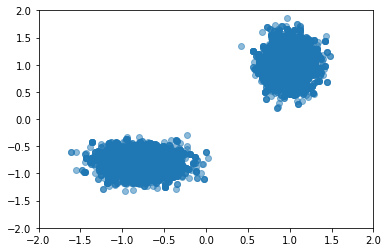

Estimated evidence by HM=0.25269154562934104


In [3]:
from UQpy.SampleMethods import Stretch, MH
seed = -2. + 4. * np.random.rand(100, 2)
mcmc0 = MH(log_pdf_target=log_target, nburn=100, jump=3, seed=seed, dimension=2, random_state=123, 
          save_log_pdf=True)
mcmc0.run(nsamples_per_chain=200)

print(mcmc0.samples.shape)
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))
ax.scatter(mcmc0.samples[:, 0], mcmc0.samples[:, 1], alpha=0.5)
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
plt.show()

def estimate_evidence_from_posterior_samples(log_posterior_values, posterior_samples):
    log_like = log_likelihood(posterior_samples) #log_posterior_values - log_prior(posterior_samples)
    ev = 1. / np.mean(1. / np.exp(log_like))
    return ev
evidence = estimate_evidence_from_posterior_samples(
    log_posterior_values=mcmc0.log_pdf_values, posterior_samples=mcmc0.samples)
print('Estimated evidence by HM={}'.format(evidence))

In [4]:
def log_factor_temp(x, temperature):
    return 1. / temperature * log_likelihood(x)# + (1. - 1. / temperature) * log_prior(x)

[1.0, 1.4142135623730951, 2.0000000000000004, 2.8284271247461907, 4.000000000000001, 5.656854249492382, 8.000000000000004, 11.313708498984766, 16.000000000000007, 22.627416997969533, 32.00000000000002, 45.25483399593907, 64.00000000000006, 90.50966799187816, 128.0000000000001, 181.01933598375635, 256.0000000000003, 362.03867196751276, 512.0000000000007, 724.0773439350256]
(1000, 2)
(1000, 2)


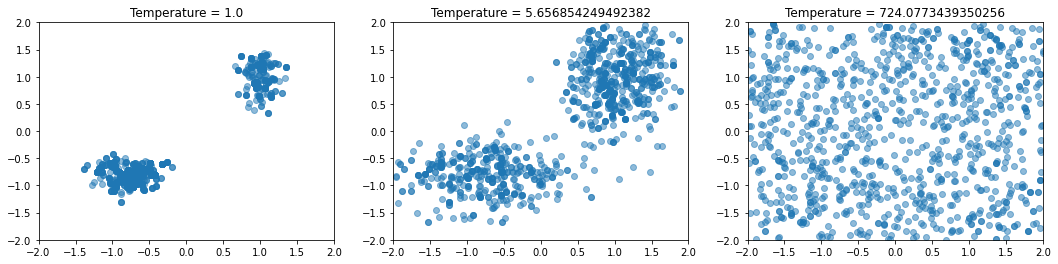

In [5]:
from UQpy.SampleMethods import Stretch, MH, ParallelTemperingMCMC
seed = -2. + 4. * np.random.rand(5, 2)
temperatures = [np.sqrt(2.) ** i for i in range(20)]
print(temperatures)
mcmc = ParallelTemperingMCMC(log_factor_tempered=log_factor_temp, log_pdf_reference=log_prior,
                             niter_between_sweeps=10, temperatures=temperatures, save_log_pdf=True,
                             mcmc_class=MH, nburn=100, jump=3, seed=seed, dimension=2, random_state=123)
mcmc.run(nsamples_per_chain=200)
print(mcmc.samples.shape)
print(mcmc.mcmc_samplers[0].samples.shape)

fig, ax = plt.subplots(ncols=3, figsize=(18, 4))
for j, ind in enumerate([0, 5, -1]):
    ax[j].scatter(mcmc.mcmc_samplers[ind].samples[:, 0], mcmc.mcmc_samplers[ind].samples[:, 1], alpha=0.5)
    ax[j].set_xlim([-2, 2])
    ax[j].set_ylim([-2, 2])
    ax[j].set_title('Temperature = {}'.format(mcmc.temperatures[ind]))
plt.show()

In [6]:
def compute_potential(x, log_factor_tempered_values, beta):
    return log_factor_tempered_values / beta

p0_rvs = -2. + 4. * np.random.rand(5000, 2)

In [8]:
log_ev = mcmc.evaluate_evidence(compute_potential=compute_potential, log_p0=0.)
print('Estimate of evidence by thermodynamic integration = {}'.format(np.exp(log_ev)))

log_ev = mcmc.evaluate_evidence(compute_potential=compute_potential, samples_p0=p0_rvs)
print('Estimate of evidence by thermodynamic integration = {}'.format(np.exp(log_ev)))

Estimate of evidence by thermodynamic integration = 0.06349004876825735
Estimate of evidence by thermodynamic integration = 0.060800259412439876


## Reliability

In a reliability context, $p_{0}$ is the pdf of the parameters and we have:

$$ q_{T}(x) = I_{T}(x) = \frac{1}{1 + \exp{ \left( \frac{G(x)}{T-1}\right)}} $$

where $G(x)$ is the performance function, negative if the system failsm, and $I_{T}(x)$ are smoothed versions of the indicator function. Then to compute the probability of failure, the potential can be computed as:

$$ U_{\beta}(x) = \frac{- \frac{G(x)}{(1-\beta)^2}}{1 + \exp{ \left( -\frac{G(x)}{1/\beta-1} \right) }} = - \frac{1 - I_{\beta}(x)}{\beta (1 - \beta)} \ln{ \left[ \frac{1 - I_{\beta}(x)}{I_{\beta}(x)} \right] }$$

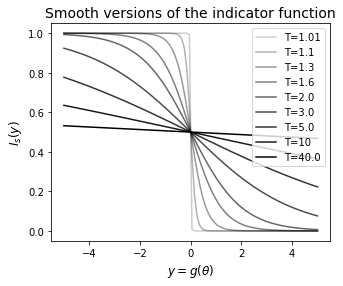

In [9]:
from scipy.stats import norm
def indic_sigmoid(y, temp):
    return 1. / (1. + np.exp(y / (temp-1.)))

fig, ax = plt.subplots(figsize=(5, 4))
ys = np.linspace(-5, 5, 100)
for i, s in enumerate([1.01, 1.1, 1.3, 1.6, 2., 3., 5., 10,  40.]):
    ax.plot(ys, indic_sigmoid(y=ys, temp=s), label='T={}'.format(s), color='black', alpha=0.2 + i/10)
ax.set_xlabel(r'$y=g(\theta)$', fontsize=12)
ax.set_ylabel(r'$I_{s}(y)$', fontsize=12)
ax.set_title(r'Smooth versions of the indicator function', fontsize=14)
ax.legend()
plt.show()

In [10]:
beta = 2 # Specified Reliability Index
rho = 0.2 # Specified Correlation
dim = 2  # Dimension

# Define the correlation matrix
C = np.ones((dim, dim)) * rho
np.fill_diagonal(C, 1)
print(C)

# Print information related to the true probability of failure
e, v = np.linalg.eig(np.asarray(C))
beff = np.sqrt(np.max(e)) * beta
print(beff)
from scipy.stats import norm
pf_true = norm.cdf(-beff)
print('True pf={}'.format(pf_true))

[[1.  0.2]
 [0.2 1. ]]
2.1908902300206643
True pf=0.014229868458155282


In [11]:
def estimate_Pf_0(samples, model_values):
    mask = model_values <= 0
    return np.sum(mask)/len(mask)

Prob. failure (MC) = 0.01394


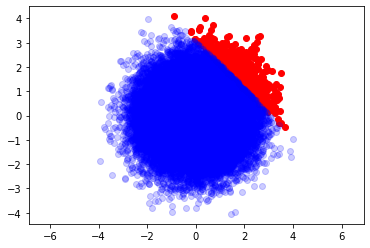

In [12]:
# Sample from the prior
model = RunModel(model_script='reliability_funcs.py', model_object_name="correlated_gaussian", ntasks=1, 
                 b_eff=beff, d=dim, model_dir=folder_uqpy_runs)
samples = MVNormal(mean=np.zeros((2,))).rvs(nsamples=50000)
model.run(samples=samples, append_samples=False)
model_values = np.array(model.qoi_list)

print('Prob. failure (MC) = {}'.format(estimate_Pf_0(samples, model_values)))

fig, ax = plt.subplots()
mask = model_values <= 0
ax.scatter(samples[mask, 0], samples[mask, 1], color='red')
ax.scatter(samples[~mask, 0], samples[~mask, 1], color='blue', alpha=0.2)
plt.axis('equal')
plt.show()

In [13]:
def log_prior(x):
    return MVNormal(mean=np.zeros((2,))).log_pdf(x)

def log_factor_temp(x, temp):
    model.run(samples=x, append_samples=False)
    G_values = np.array(model.qoi_list)
    return np.log(indic_sigmoid(G_values, temp))

In [14]:
temperatures = [1.01, 1.1, 1.3, 1.6, 2., 3., 5., 10,  40.]
#temperatures = [np.sqrt(2.) ** i for i in range(10)]

kwargs_mcmc = {'proposal_is_symmetric': [True, ] * len(temperatures),
                'proposal': [JointInd([Normal(scale=0.1 * temp)] * 2) for temp in temperatures]}

[1.01, 1.1, 1.3, 1.6, 2.0, 3.0, 5.0, 10, 40.0]
(1250, 2)
(1250, 2)


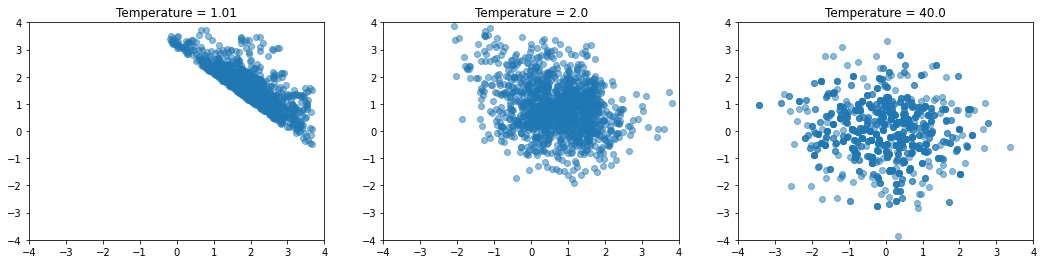

In [15]:
from UQpy.SampleMethods import MH, ParallelTemperingMCMC
seed = -2. + 4. * np.random.rand(5, 2)

print(temperatures)
mcmc = ParallelTemperingMCMC(log_factor_tempered=log_factor_temp, log_pdf_reference=log_prior,
                             niter_between_sweeps=10, temperatures=temperatures, save_log_pdf=True,
                             mcmc_class=MH, nburn=200, jump=4, seed=seed, dimension=2, random_state=123,
                             **kwargs_mcmc)
mcmc.run(nsamples_per_chain=250)
print(mcmc.samples.shape)
print(mcmc.mcmc_samplers[0].samples.shape)

fig, ax = plt.subplots(ncols=3, figsize=(18, 4))
for j, ind in enumerate([0, 4, -1]):
    ax[j].scatter(mcmc.mcmc_samplers[ind].samples[:, 0], mcmc.mcmc_samplers[ind].samples[:, 1], alpha=0.5)
    ax[j].set_xlim([-4, 4])
    ax[j].set_ylim([-4, 4])
    ax[j].set_title('Temperature = {}'.format(mcmc.temperatures[ind]))
plt.show()

In [17]:
def compute_potential(x, log_factor_tempered_values, beta):
    indic_beta = np.exp(log_factor_tempered_values)
    indic_beta = np.where(indic_beta > 1. - 1e-16, 1. - 1e-16, indic_beta)
    indic_beta = np.where(indic_beta < 1e-16, 1e-16, indic_beta)
    tmp_log = np.log((1. - indic_beta) / indic_beta)
    return - (1. - indic_beta) / (beta * (1. - beta)) * tmp_log

p0_rvs = np.random.randn(10000, 2)

In [19]:
log_ev = mcmc.evaluate_evidence(compute_potential=compute_potential, samples_p0=p0_rvs)
print('Estimate of evidence by thermodynamic integration = {}'.format(np.exp(log_ev)))

Estimate of evidence by thermodynamic integration = 0.014794399313252066
